This notebook shows how to fit a Bayesian Gaussian mixture model using stochastic variational inference, with TensorFlow Probability (TFP) and TensorFlow 2.0.

Let's load the packages we'll use.  Note that you need the [TFP nightly build](https://www.tensorflow.org/probability/install#nightly_builds) to use TFP with TF 2.0 (as of 2019-06-12).

In [0]:
# Install packages
!pip install tensorflow==2.0.0-beta0 -q
!pip install --upgrade tfp-nightly -q

# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Plot settings
%config InlineBackend.figure_format = 'svg'

# Random seed
np.random.seed(12345)
tf.random.set_seed(12345)

## Data

Let's generate some points in 2D space, which form 3 clusters.

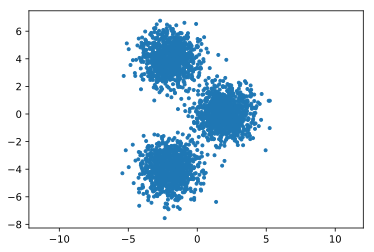

In [2]:
# Generate some data
N = 3000
X = np.random.randn(N, 2).astype('float32')
X[:1000, :] += [2, 0]
X[1000:2000, :] -= [2, 4]
X[2000:, :] += [-2, 4]

# Plot the data
plt.plot(X[:, 0], X[:, 1], '.')
plt.axis('equal')
plt.show()

The recommended way to feed data through a model in TF 2.0 is to use [the tf.data API](https://www.tensorflow.org/guide/datasets) (as opposed to the old `feed_dict` mechanism).  So, let's create a TF Dataset which contains the data points from above.

In [3]:
# Make a TensorFlow Dataset from that data
batch_size = 500
dataset = tf.data.Dataset.from_tensor_slices(
    (X)).shuffle(10000).batch(batch_size)

W0613 04:56:29.335068 139962006239104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Math

Let's model the data-generating distribution with a Bayesian Gaussian mixture model.  The model has $k \in \{1, ..., K\}$ mixture components - we'll use multivariate normal distributions.  To match the data we generated, we'll use $K=3$ mixture components in $D=2$ dimensions.

We'll use [stochastic variational inference](http://www.jmlr.org/papers/v14/hoffman13a.html) to fit the mixture model.  Briefly, this means that to go from the non-Bayesian model to a variational Bayesian model, we'll replace each point parameter of our model with a probability distribution, called the "variational posterior".  Then we'll optimize the variables of those variational posterior distributions to be as close as possible to the true posteriors.  [See here](https://probflow.readthedocs.io/en/latest/math.html) for more info.

Each of the 3 normal distributions has a mean ($\mu$).  To probabilistically model the means, we'll use a normal distribution as the variational posterior for the mean of each component ($k$) in each dimension ($d$):

$$
\mu_{k,d} \sim \text{Normal} ( l_{k,d}, ~ s_{k,d} )
$$

where $l$ and $s$ are two variables which we will be trying to fit, corresponding to the mean and standard deviation of the component means' variational posteriors, respectively.

Each of the 3 normal distributions also has a standard deviation ($\sigma$).   We'll use a square-root inverse [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) as the variational posterior for the standard deviation of each component in each dimension ([why?](https://probflow.readthedocs.io/en/latest/parameters.html#scale-parameters)):

$$
\sigma_{k,d}^{-2} \sim \text{Gamma} ( \alpha_{k,d}, ~ \beta_{k,d} )
$$

where again $\alpha$ and $\beta$ are two variables we'll be trying to fit, corresponding to the shape and rate parameters of the Gamma variational posterior.

Each of the 3 mixture components also has a weight, $\theta$, such that all 3 weights sum to 1.  To model these weights, we'll use a [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) as the variational posterior:

$$
\theta_k \sim \text{Dirichlet} ( \mathbf{c} )
$$

where $\mathbf{c}$ is a $K$-length vector of variables we'll be trying to fit, corresponding to the concentration parameters of the Dirichlet variational posterior.  These concentration parameters determine how heavily to weight each mixture component.

Finally, the probability of a data point being generated by any of the mixture components is modeled with a categorical distribution with observation probabilities according to $\theta$:

$$
Z_i \sim \text{Categorical} (\theta)
$$

and then the likelihood of a data point is determined by that mixture component:

$$
Y_i \sim \text{Normal} ( \mu_k, ~ \sigma_k )
$$

We'll put some priors on the parameters to regularize things a bit:

$$
\mu_{k,d} \sim \text{Normal} ( 0, 1 ) \\
\sigma_{k,d}^{-2} \sim \text{Gamma} ( 5, 5 ) \\
\theta_k \sim \text{Dirichlet} ([2, 2, 2])
$$

## Model

To build this model in TensorFlow, we'll use the [model subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing).  This way we can build a class to represent the model, and it makes it easier to fit the model and access its variables.

In the constructor (`__init__`), we'll create all the variables ($l, s, \alpha, \beta\,$ and $\mathbf{c}$) and define the priors.

In the `call` method, we'll use TensorFlow to set up two computations.  First, the log likelihood of each datapoint in the batch, given the model and the current value of the variational posterior's variables.  And second, the sum of the Kullback–Leibler divergence between the variational posteriors and their priors. 

In [0]:
class GaussianMixtureModel(tf.keras.Model):
    """A Bayesian Gaussian mixture model.
    
    Assumes Gaussians' variances in each dimension are independent.
    
    Parameters
    ----------
    Nc : int > 0
        Number of mixture components.
    Nd : int > 0
        Number of dimensions.
    """
      
    def __init__(self, Nc, Nd):
        
        # Initialize
        super(GaussianMixtureModel, self).__init__()
        self.Nc = Nc
        self.Nd = Nd
        
        # Variational distribution variables for means
        self.locs = tf.Variable(tf.random.normal((Nc, Nd)))
        self.scales = tf.Variable(tf.pow(tf.random.gamma((Nc, Nd), 5, 5), -0.5))
        
        # Variational distribution variables for standard deviations
        self.alpha = tf.Variable(tf.random.uniform((Nc, Nd), 4., 6.))
        self.beta = tf.Variable(tf.random.uniform((Nc, Nd), 4., 6.))
        
        # Variational distribution variables for component weights
        self.counts = tf.Variable(2*tf.ones((Nc,)))

        # Prior distributions for the means
        self.mu_prior = tfd.Normal(tf.zeros((Nc, Nd)), tf.ones((Nc, Nd)))

        # Prior distributions for the standard deviations
        self.sigma_prior = tfd.Gamma(5*tf.ones((Nc, Nd)), 5*tf.ones((Nc, Nd)))
        
        # Prior distributions for the component weights
        self.theta_prior = tfd.Dirichlet(2*tf.ones((Nc,)))
        
        
        
    def call(self, x, sampling=True, independent=True):
        """Compute losses given a batch of data.
        
        Parameters
        ----------
        x : tf.Tensor
            A batch of data
        sampling : bool
            Whether to sample from the variational posterior
            distributions (if True, the default), or just use the
            mean of the variational distributions (if False).
            
        Returns
        -------
        log_likelihoods : tf.Tensor
            Log likelihood for each sample
        kl_sum : tf.Tensor
            Sum of the KL divergences between the variational
            distributions and their priors
        """
        
        # The variational distributions
        mu = tfd.Normal(self.locs, self.scales)
        sigma = tfd.Gamma(self.alpha, self.beta)
        theta = tfd.Dirichlet(self.counts)
        
        # Sample from the variational distributions
        if sampling:
            Nb = x.shape[0] #number of samples in the batch
            mu_sample = mu.sample(Nb)
            sigma_sample = tf.pow(sigma.sample(Nb), -0.5)
            theta_sample = theta.sample(Nb)
        else:
            mu_sample = tf.reshape(mu.mean(), (1, self.Nc, self.Nd))
            sigma_sample = tf.pow(tf.reshape(sigma.mean(), (1, self.Nc, self.Nd)), -0.5)
            theta_sample = tf.reshape(theta.mean(), (1, self.Nc))
        
        # The mixture density
        density = tfd.Mixture(
            cat=tfd.Categorical(probs=theta_sample),
            components=[
                tfd.MultivariateNormalDiag(loc=mu_sample[:, i, :],
                                           scale_diag=sigma_sample[:, i, :])
                for i in range(self.Nc)])
                
        # Compute the mean log likelihood
        log_likelihoods = density.log_prob(x)
        
        # Compute the KL divergence sum
        mu_div    = tf.reduce_sum(tfd.kl_divergence(mu,    self.mu_prior))
        sigma_div = tf.reduce_sum(tfd.kl_divergence(sigma, self.sigma_prior))
        theta_div = tf.reduce_sum(tfd.kl_divergence(theta, self.theta_prior))
        kl_sum = mu_div + sigma_div + theta_div
        
        # Return both losses
        return log_likelihoods, kl_sum

Now, we can instantiate this model with $K=3$ mixture components in $D=2$ dimensions.

In [0]:
# A GMM with 3 components in 2 dimensions
model = GaussianMixtureModel(3, 2)

We'll use the Adam optimizer:

In [0]:
# Use the Adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

Next we'll define a function which performs a training step: compute the gradients of the variables controlling the variational posterior distributions with respect to the loss, and use the optimizer to update those variables.  

The loss that we're using is the negative evidence lower bound (ELBO).  Two factors contribute to the ELBO loss: the log likelihood of the data given the model with the current parameter values, and the KL divergence between the variational posterior distributions and their priors.

Note that because we're using minibatches, we have to ensure the loss from these two sources are on the same scale!  To get both terms on the same scale, we'll take the average log likelihood, but divide the sum of the divergences by the total number of data points in the dataset (*not* by the number of samples in the minibatch).

In [0]:
@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        log_likelihoods, kl_sum = model(data)
        elbo_loss = kl_sum/N - tf.reduce_mean(log_likelihoods)
    gradients = tape.gradient(elbo_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Fitting the Model

Now that we've set everything up, we can fit the model.  Using the `train_step` function we defined above, and having defined the TF Dataset, this is pretty simple:

In [8]:
# Fit the model
EPOCHS = 1000
for epoch in range(EPOCHS):
    for data in dataset:
        train_step(data)

W0613 04:56:30.323180 139962006239104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


## Inspecting the Model

We can look at the fit mixture density, which matches the distribution of the data pretty well:

Text(0, 0.5, 'Likelihood')

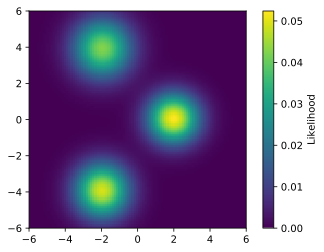

In [9]:
# Compute log likelihood at each point on a grid
Np = 100 #number of grid points
Xp, Yp = np.meshgrid(np.linspace(-6, 6, Np), np.linspace(-6, 6, Np))
Pp = np.column_stack([Xp.flatten(), Yp.flatten()]).astype('float32')
Z, _ = model(Pp, sampling=False)
Z = np.reshape(Z, (Np, Np))
        
# Show the fit mixture density
plt.imshow(np.exp(Z),
           extent=(-6, 6, -6, 6),
           origin='lower')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Likelihood')

We can also access the individual variables of the variational posterior distributions:

In [10]:
model.locs

<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[-1.9940692 , -3.9678814 ],
       [ 1.9868133 ,  0.04222748],
       [-1.9703939 ,  3.9488075 ]], dtype=float32)>

And, because we used the model subclassing API, we can easily get a list of all the variables in the model:

In [11]:
model.trainable_variables

[<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
 array([[-1.9940692 , -3.9678814 ],
        [ 1.9868133 ,  0.04222748],
        [-1.9703939 ,  3.9488075 ]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
 array([[0.03294131, 0.03626651],
        [0.02990762, 0.0270258 ],
        [0.0353109 , 0.03238053]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
 array([[5.331946 , 4.7754154],
        [5.345971 , 5.4955726],
        [3.9365306, 3.9941833]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
 array([[5.776071 , 5.406686 ],
        [5.2300854, 5.1007385],
        [5.003031 , 5.167815 ]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([4.905027 , 4.49357  , 4.9185777], dtype=float32)>]

We can view the variational posterior distributions.  For example, the standard deviation of the first mixture component in the first dimension:

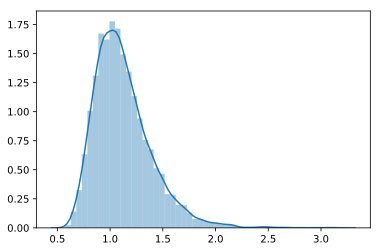

In [12]:
# Sample from the std deviation variational posterior
stds = tf.pow(tfd.Gamma(model.alpha, model.beta).sample(10000), -0.5)

# Plot the samples
sns.distplot(stds[:, 0, 0])

And also the variational joint distributions of the means of the first mixture component:

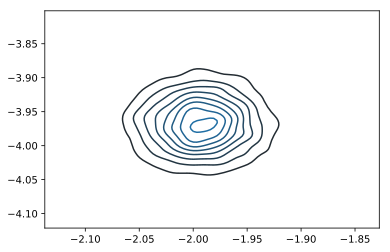

In [13]:
# Sample from the mean variational posterior
means = tfd.Normal(model.locs, model.scales).sample(10000)

# Plot the mean samples for a single 
sns.kdeplot(means[:, 0, 0].numpy(),
            means[:, 0, 1].numpy(),
            n_levels=10)

## Identifiability

Note that the code above completely ignored the [identifiability](https://en.wikipedia.org/wiki/Identifiability) problem!  That is, who's to say that mixture component 1 is on the top-left and mixture component 2 in the lower-left?  Both the likelihood and the KL loss could be exactly the same if the parameters for each were swapped.  

Mixture models suffer pretty badly from identifiability problems, because any two of the mixture components can be swapped without changing the posterior probability of the model.  Also, if multiple mixture components overlap, their component weights can take any linear combination of values (e.g. 0.3 and 0.2 vs 0.1 and 0.4).  There are ways to help fix these problems, such as enforcing ordering constraints or using different priors for different mixture components ([see this case study](https://mc-stan.org/users/documentation/case-studies/identifying_mixture_models.html)).  But, keep in mind that the code here didn't do any of that!